In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from nilearn.plotting import plot_design_matrix
import statsmodels.api as sm

sys.path.append('/Users/jeanettemumford/Dropbox/Research/Projects/patrick/efficiency_rdoc')

from utils import (calc_expected_run_num_by_chance, sample_shifted_truncated_exponential, 
                   est_eff_and_vif, est_psych_fitness, run_eff_sim)

## Spatial cueing task

We're still ironing out the details of the model, but I believe the task layout is correct.

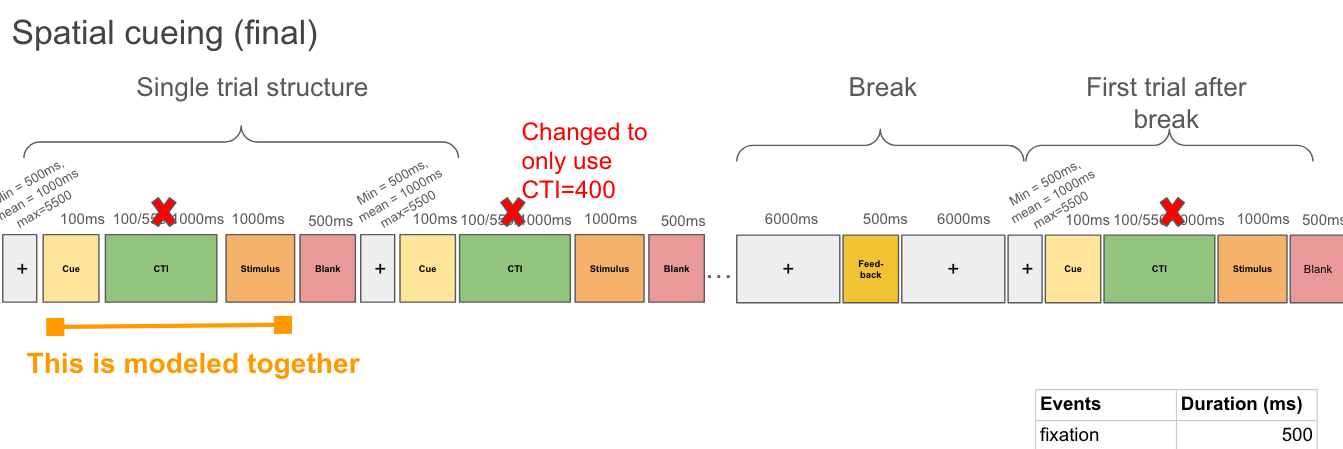

In [2]:
def make_spatial_cueing_timings(n_no_cue, n_double_cue, n_valid_cue, n_invalid_cue, cue_dur, cti_durs, stim_dur, blank_dur,  
                             nbreaks, break_fix_pre_message_dur, break_message_dur,  
                             break_fix_post_message_dur, isi_exp_lam, isi_truncation, 
                             isi_shift, model_option):
    '''
    Produces a randomly ordered set of trials for the spatial cueing task.
    Assumes a break between blocks of task.  Number of no_cue/double_cue/valid_cue trials will be equal
    for each block of the task 
    ISI is sampled from a truncated exponential.  Note the truncation value for the
    truncated exponential does *not* include the shift, so the max isi is
    isi_truncation + isi_shift.
    A trial is structured as:
      fixation (based on truncated exponential) + 
      cue(cue_dur) + CTI (3 values for duration) + stimulus (stim_dur) + blank (blank_dur) + 
      next trial (same structure as above until end of block is reached)
      At end of block the break begins with:
      fixation (length=break_dur) + 
      break message (break_message_dur) + 
      post message fixation (post_message_dur)
    Input:
      n_no_cue, n_double_cue, n_valid_cue: Total number of no_cue/double_cue/valid_cue trials 
          (will be evenly split between blocks) Integer divisible by (nbreaks + 1)
      cue_dur/cti_dur/stim_dur/blank_dur: Durations of cue/cti/stim/blank.  
                                          All are integers, but cti, which is a vector of 3 values
      break_fix_pre_message_dur: Fixation duration at beginning of break (no jittering)
      break_message_dur:  Duration of message shown during break
      break_fix_post_message_dur:  Fixation duration after message (no jittering)
      isi_exp_lam:  (seconds) The lambda parameter of the exponential used for the isi 
                    (inverse is the non-truncated/non-shifted mean)
      isi_truncation: (seconds) Truncation value of the exponential *NOT* including shift.  
                      Max ISI = isi_truncation + isi_shift
      isi_shift: (seconds) Shift value for isi (minimum isi value)
      model_option: One of ['one_component', 'two_components', 'three_components'].  Refers to how cue
                    cti and stimulus are modeled.  Three components models them separately, two models cue+cti together,
                    and one component models cue+cti+stimulus as a single regressor.
    Output:
       Events pandas data frame with onsets, trial_type and duration.  
    '''
    
    nblocks = nbreaks + 1
    ntrials = n_no_cue + n_double_cue +  n_valid_cue + n_invalid_cue
    ntrials_per_block = int(ntrials/nblocks)
    n_no_cue_per_block = int(n_no_cue / (nblocks))
    n_double_cue_per_block = int(n_double_cue / (nblocks))
    n_valid_cue_per_block = int(n_valid_cue / (nblocks))     
    n_invalid_cue_per_block = int(n_invalid_cue / (nblocks))
    isi_vals, _ = sample_shifted_truncated_exponential(isi_exp_lam, isi_truncation, 
                                                    isi_shift, ntrials)

    # Each stimulus has 3 fragments and each break has 3 fragments
    isi_count = 0
    fragment_durations = []
    fragment_labels = []
    for cur_block in range(nblocks):
        cue_types = ['no_cue', 'double_cue', 'valid_cue', 'invalid_cue']
        cue_nums = [n_no_cue_per_block, n_double_cue_per_block, n_valid_cue_per_block, n_invalid_cue_per_block]
        stim_type_cti_val = []
        num_cti_vals = len(cti_durs)
        for cue_type, cue_num in zip(cue_types, cue_nums):
            for cti_dur in cti_durs:
                stim_type_cti_val.extend([[cue_type, cti_dur]]*int(cue_num/num_cti_vals))
        stim_type_cti_val_perm = np.random.permutation(np.array(stim_type_cti_val)) 
        for cur_trial in range(ntrials_per_block):
            cur_stim_type = stim_type_cti_val_perm[cur_trial,0]
            cur_cti_dur_s = float(stim_type_cti_val_perm[cur_trial,1])
            if model_option == 'three_components':
                fragment_durations.extend([isi_vals[isi_count], cue_dur, cur_cti_dur_s, stim_dur, blank_dur])
                fragment_labels.extend(['isi_fix', f'cue_{cur_stim_type}', 'cti', f'stim_{cur_stim_type}_{int(1000*cur_cti_dur_s)}', 'blank'])
            if model_option == 'two_components':
                fragment_durations.extend([isi_vals[isi_count], cue_dur + cur_cti_dur_s, stim_dur, blank_dur])
                fragment_labels.extend(['isi_fix', f'cue_{cur_stim_type}_cti', f'stim_{cur_stim_type}_{int(1000*cur_cti_dur_s)}', 'blank'])
            if model_option == 'one_component':
                fragment_durations.extend([isi_vals[isi_count], cue_dur + cur_cti_dur_s + stim_dur, blank_dur])
                fragment_labels.extend(['isi_fix', f'cue_cti_stim_{cur_stim_type}_{int(1000*cur_cti_dur_s)}', 'blank'])
            isi_count = isi_count + 1
        #Add break
        fragment_durations.extend([break_fix_pre_message_dur, break_message_dur, break_fix_post_message_dur])
        fragment_labels.extend(['fix_break', 'break_message', 'fix_break'])

    # If you don't want the beginning of the run to start at 0, change this 
    # (e.g. if you want to add the 10s to reach steady state)
    run_start = 0
    fragment_onsets = np.cumsum([run_start] + fragment_durations)[:-1]       
    events_data = pd.DataFrame({'onset': fragment_onsets,
                                'trial_type': fragment_labels,
                                'duration': fragment_durations})
    events_data = events_data.loc[events_data['trial_type'].str.contains('cue|cti|stim|break_message')==True]
    return events_data

In [3]:
events_inputs = {
    'n_no_cue': 72,
    'n_double_cue': 72,
    'n_valid_cue': 54,
    'n_invalid_cue': 18,
    'cue_dur': .1,
    'cti_durs': [.4],
    'stim_dur': 1,
    'blank_dur': .5,
    'nbreaks': 2,
    'break_fix_pre_message_dur': 6,
    'break_message_dur': 4,
    'break_fix_post_message_dur': 6,
    'isi_exp_lam': 2,
    'isi_truncation': 4.5,
    'isi_shift': .5
}

tr = 1.49
total_time = 13*55
contrasts_three_two_components = {'double_400-no_cue_400': 'stim_double_cue_400-stim_no_cue_400',
             'valid_400-double_400': 'stim_valid_cue_400-stim_double_cue_400',
             'invalid_400-double_400': 'stim_invalid_cue_400-stim_double_cue_400'
             }
contrasts_one_component = {'double_400-no_cue_400': 'cue_cti_stim_double_cue_400-cue_cti_stim_no_cue_400',
             'valid_400-double_400': 'cue_cti_stim_valid_cue_400-cue_cti_stim_double_cue_400',
             'invalid_400-double_400': 'cue_cti_stim_invalid_cue_400-cue_cti_stim_double_cue_400'
             }

In [4]:
trials_psych_assess_map = {'cue_no_cue': '1', 'cue_double_cue': '2', 'cue_valid_cue': '3', 'cue_invalid_cue': '4'}

ntrials = events_inputs['n_no_cue'] + events_inputs['n_double_cue'] +  events_inputs['n_valid_cue'] + events_inputs['n_invalid_cue']
unpermuted_trials = np.concatenate([np.repeat('1', int(events_inputs['n_no_cue']/3)), 
                                    np.repeat('2', int(events_inputs['n_double_cue']/3)),
                                    np.repeat('3', int(events_inputs['n_valid_cue']/3)),
                                    np.repeat('4', int(events_inputs['n_invalid_cue']/3))],
                                    axis=0)
avg_trial_repeats_info = calc_expected_run_num_by_chance(unpermuted_trials, nsims=5000)

for val in ['1', '2', '3', '4']:
    avg_trial_repeats_info[f'{val}_run_counts'] = avg_trial_repeats_info[f'{val}_run_counts'] * 3
print(avg_trial_repeats_info)

    run_length  1_run_counts  2_run_counts  3_run_counts  4_run_counts
0          1.0       32.4438       32.6658       30.8928       15.3234
1          2.0       10.9008       10.8354        7.4808        1.1196
2          3.0        3.4794        3.4626        1.8042        0.0708
3          4.0        1.0410        1.0572        0.4050        0.0018
4          5.0        0.3264        0.3108        0.0876        0.0006
5          6.0        0.1002        0.0960        0.0138        0.0000
6          7.0        0.0228        0.0240        0.0012        0.0000
7          8.0        0.0066        0.0084        0.0000        0.0000
8          9.0        0.0024        0.0012        0.0000        0.0000
9         10.0        0.0000        0.0000        0.0000        0.0000
10        11.0        0.0000        0.0000        0.0000        0.0000
11        12.0        0.0000        0.0000        0.0000        0.0000
12        13.0        0.0000        0.0000        0.0000        0.0000
13    

### Quick look at VIFs for the 3 designs

Below I run a single model and look at VIFs when the 3 subcomponents of the trial (cue/cti/stimulus) are modeled separately versus modeling cue&cti as a single regressor while stimulus is separate, versus modeling all 3 components in a single regressor.

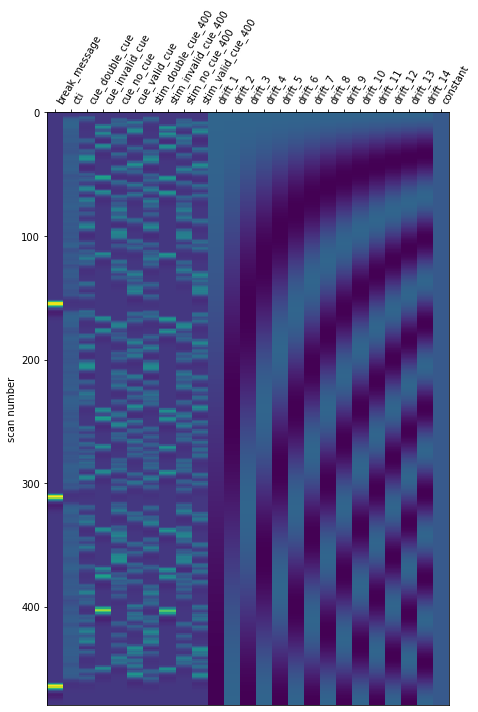

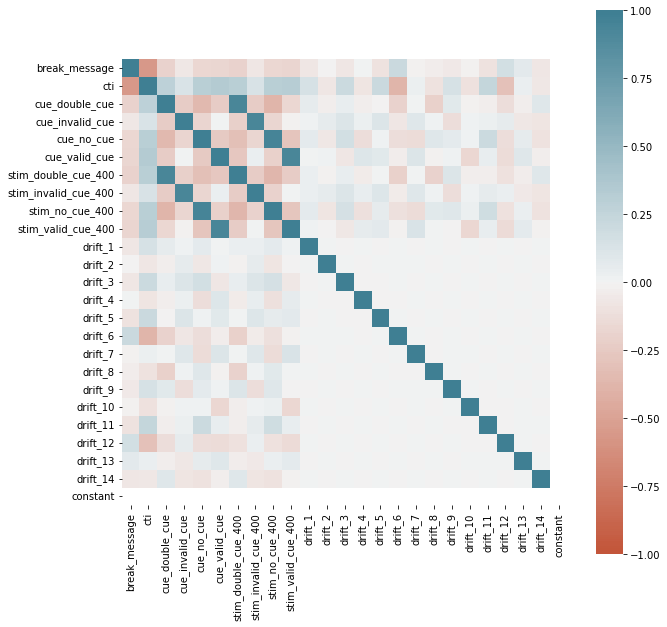

{'double_400-no_cue_400': 9.726225942321415, 'valid_400-double_400': 7.651135722084682, 'invalid_400-double_400': 9.236539835930776}


In [5]:
#original design

events_inputs['model_option'] = 'three_components'
events_ts = make_spatial_cueing_timings(**events_inputs)
eff, vif, desmat = est_eff_and_vif(events_ts, tr, total_time, contrasts_three_two_components, deriv=False)

plot_design_matrix(desmat)
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(
    desmat.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax
)
plt.show()

print(vif)

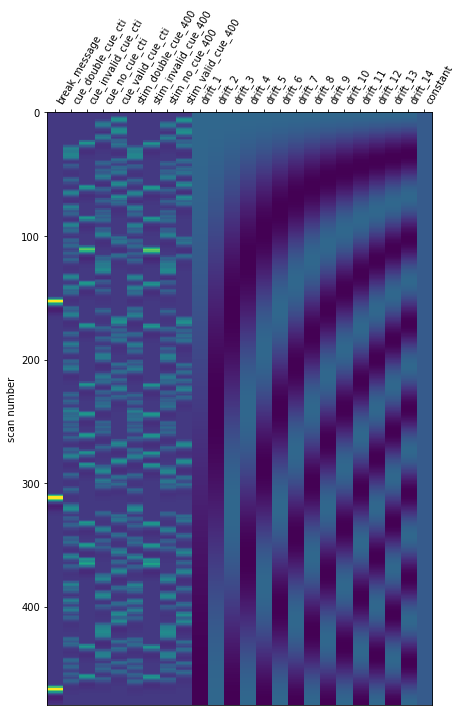

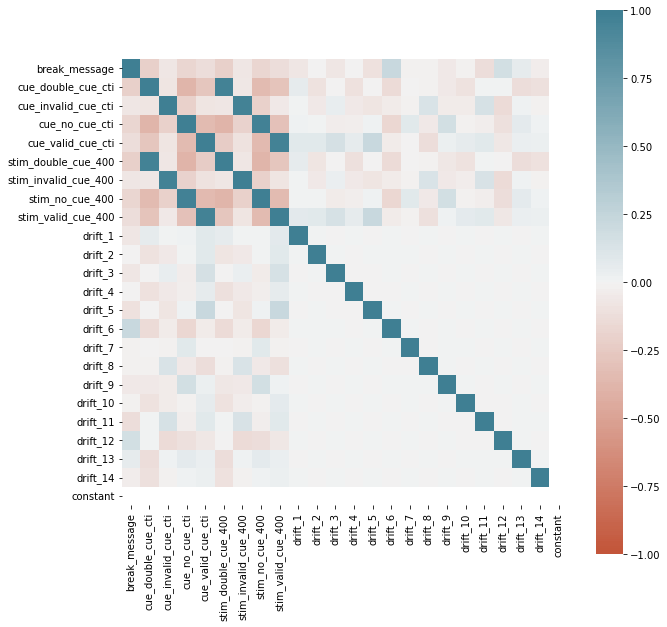

{'double_400-no_cue_400': 16.428932426454214, 'valid_400-double_400': 14.1874590980828, 'invalid_400-double_400': 13.569814430944128}


In [6]:
#Omitting CTI regressor and modeling CTI period with cue period.

events_inputs['model_option'] = 'two_components'
events_ts = make_spatial_cueing_timings(**events_inputs)
eff, vif, desmat = est_eff_and_vif(events_ts, tr, total_time, contrasts_three_two_components, deriv=False)

plot_design_matrix(desmat)
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(
    desmat.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax
)
plt.show()

print(vif)

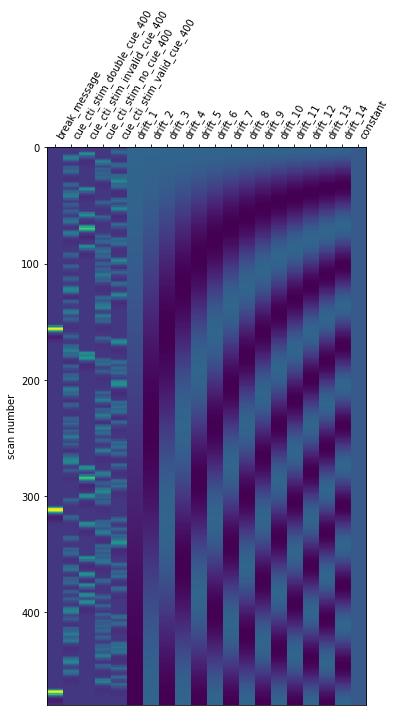

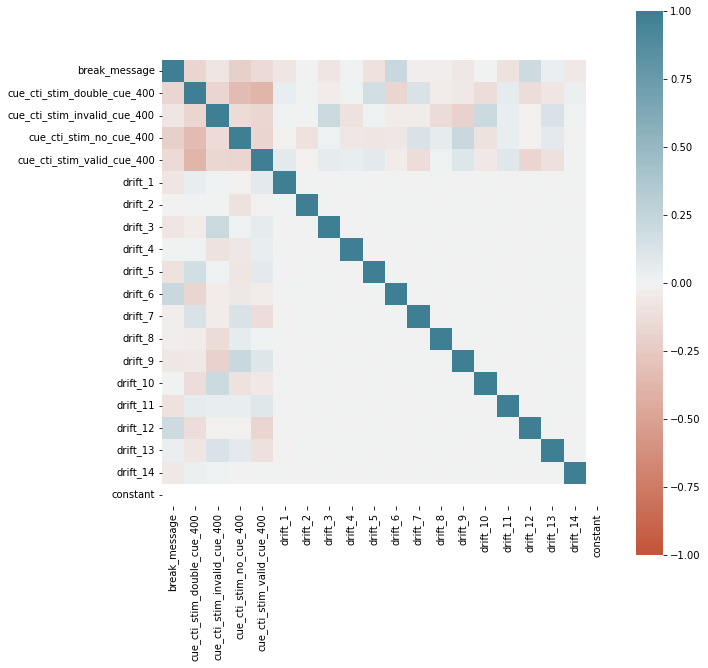

{'double_400-no_cue_400': 1.1554575727763456, 'valid_400-double_400': 1.0590320635085047, 'invalid_400-double_400': 1.2063243179318832}


In [7]:
events_inputs['model_option'] = 'one_component'
events_ts = make_spatial_cueing_timings(**events_inputs)
eff, vif, desmat = est_eff_and_vif(events_ts, tr, total_time, contrasts_one_component, deriv=False)

plot_design_matrix(desmat)
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(
    desmat.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax
)
plt.show()

print(vif)

## Modeling each component of the trial separately

In [8]:
events_inputs['model_option'] = 'three_components'

nsim = 250
output_setting_three_comp, events_setting_three_comp = run_eff_sim(nsim, events_inputs, make_spatial_cueing_timings, 
                               contrasts_three_two_components, avg_trial_repeats_info, tr, total_time,
                               trials_psych_assess_map, deriv=False)

In [9]:
#g = sns.PairGrid(output_setting_three_comp)
#g.map_diag(sns.histplot)
#g.map_offdiag(sns.scatterplot)
#g.savefig('/Users/jeanettemumford/Desktop/junk.pdf', format="pdf", bbox_inches="tight")

In [10]:
pd.set_option('display.width', 1000)
summary_names = [f'eff_{name}' for name in contrasts_three_two_components.keys()] + \
                [f'vif_{name}' for name in contrasts_three_two_components.keys()] + \
                ['scan_length']

eff_vif_summaries_gng = {}
eff_vif_summaries_gng['setting: separate cue, cti, stim']= np.round(output_setting_three_comp[summary_names].quantile(q=[.05, .5, .95]), 2)

for key, val in eff_vif_summaries_gng.items():
    print(f'Results for {key}')
    print(val)

Results for setting: separate cue, cti, stim
      eff_double_400-no_cue_400  eff_valid_400-double_400  eff_invalid_400-double_400  vif_double_400-no_cue_400  vif_valid_400-double_400  vif_invalid_400-double_400  scan_length
0.05                       0.41                      0.35                        0.16                       7.63                      7.61                        7.81       697.98
0.50                       0.46                      0.40                        0.18                       9.06                      9.04                        9.07       710.63
0.95                       0.51                      0.44                        0.20                      10.46                     10.74                       10.93       721.11


### Modeling cue and cti together
One cue/cti regressor and one stimulus regressor (for each cue type)

In [11]:
events_inputs['model_option'] = 'two_components'
trials_psych_assess_map = {'cue_no_cue_cti': '1', 'cue_double_cue_cti': '2', 'cue_valid_cue_cti': '3', 'cue_invalid_cue_cti': '4'}

nsim = 250
output_setting_two_comp, events_setting_two_comp = run_eff_sim(nsim, events_inputs, make_spatial_cueing_timings, 
                               contrasts_three_two_components, avg_trial_repeats_info, tr, total_time,
                               trials_psych_assess_map, deriv=False)

In [12]:
eff_vif_summaries_gng['setting: two components (cue+cti and stim)']= np.round(output_setting_two_comp[summary_names].quantile(q=[.05, .5, .95]), 2)

for key, val in eff_vif_summaries_gng.items():
    print(f'Results for {key}')
    print(val)

Results for setting: separate cue, cti, stim
      eff_double_400-no_cue_400  eff_valid_400-double_400  eff_invalid_400-double_400  vif_double_400-no_cue_400  vif_valid_400-double_400  vif_invalid_400-double_400  scan_length
0.05                       0.41                      0.35                        0.16                       7.63                      7.61                        7.81       697.98
0.50                       0.46                      0.40                        0.18                       9.06                      9.04                        9.07       710.63
0.95                       0.51                      0.44                        0.20                      10.46                     10.74                       10.93       721.11
Results for setting: two components (cue+cti and stim)
      eff_double_400-no_cue_400  eff_valid_400-double_400  eff_invalid_400-double_400  vif_double_400-no_cue_400  vif_valid_400-double_400  vif_invalid_400-double_400  scan_length


In [13]:
events_inputs['model_option'] = 'one_component'
trials_psych_assess_map = {'cue_cti_stim_no_cue_400': '1', 'cue_cti_stim_double_cue_400': '2', 'cue_cti_stim_valid_cue_400': '3', 'cue_cti_stim_invalid_cue_400': '4'}

nsim = 250
output_setting_one_comp, events_setting_one_comp = run_eff_sim(nsim, events_inputs, make_spatial_cueing_timings, 
                               contrasts_one_component, avg_trial_repeats_info, tr, total_time,
                               trials_psych_assess_map, deriv=False)

In [14]:
eff_vif_summaries_gng['setting: one component (cue+cti+stim modeled a single event)']= np.round(output_setting_one_comp[summary_names].quantile(q=[.05, .5, .95]), 2)

for key, val in eff_vif_summaries_gng.items():
    print(f'Results for {key}')
    print(val)

Results for setting: separate cue, cti, stim
      eff_double_400-no_cue_400  eff_valid_400-double_400  eff_invalid_400-double_400  vif_double_400-no_cue_400  vif_valid_400-double_400  vif_invalid_400-double_400  scan_length
0.05                       0.41                      0.35                        0.16                       7.63                      7.61                        7.81       697.98
0.50                       0.46                      0.40                        0.18                       9.06                      9.04                        9.07       710.63
0.95                       0.51                      0.44                        0.20                      10.46                     10.74                       10.93       721.11
Results for setting: two components (cue+cti and stim)
      eff_double_400-no_cue_400  eff_valid_400-double_400  eff_invalid_400-double_400  vif_double_400-no_cue_400  vif_valid_400-double_400  vif_invalid_400-double_400  scan_length
